In [22]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
import pickle

In [23]:
path = "/content/drive/MyDrive/datasets/real_estate_dataset.csv"
df = pd.read_csv(path)
df.sample(7)

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
11,12,292.477463,2,1,3,1935,1,1,27,6.716423,6.220050,677623.466782
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
198,199,271.771606,2,2,3,1985,0,1,47,6.096310,0.314858,762589.629171
365,366,146.525659,3,2,2,1952,1,1,18,0.504889,13.970613,554021.149990
143,144,125.219577,5,1,3,1991,0,0,43,7.191599,12.735234,682189.630583
475,476,298.241199,3,3,2,1907,0,1,26,2.714988,6.644111,666405.154193
130,131,154.352751,2,3,2,1954,1,1,15,8.472717,17.230274,562560.446333


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    int64  
 7   Has_Pool            500 non-null    int64  
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB


**Note:** There are no missing values, and all features are numeric, so feature encoding is not required.

In [26]:
# Quick descriptive statistic
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,500.0,250.500000,144.481833,1.000000,125.750000,250.500000,375.250000,500.000000
Square_Feet,500.0,174.640428,74.672102,51.265396,110.319923,178.290937,239.031220,298.241199
Num_Bedrooms,500.0,2.958000,1.440968,1.000000,2.000000,3.000000,4.000000,5.000000
Num_Bathrooms,500.0,1.976000,0.820225,1.000000,1.000000,2.000000,3.000000,3.000000
Num_Floors,500.0,1.964000,0.802491,1.000000,1.000000,2.000000,3.000000,3.000000
Year_Built,500.0,1957.604000,35.491781,1900.000000,1926.000000,1959.000000,1988.000000,2022.000000
Has_Garden,500.0,0.536000,0.499202,0.000000,0.000000,1.000000,1.000000,1.000000
Has_Pool,500.0,0.492000,0.500437,0.000000,0.000000,0.000000,1.000000,1.000000
Garage_Size,500.0,30.174000,11.582575,10.000000,20.000000,30.000000,41.000000,49.000000
Location_Score,500.0,5.164410,2.853489,0.004428,2.760650,5.206518,7.732933,9.995439


In [27]:
duplicate_records = df.duplicated().sum()
print(f"Number of duplicated records present: {duplicate_records}")

Number of duplicated records present: 0


In [28]:
# Drop the unncesarry (not informative) columns
df.drop("ID", axis=1, inplace=True)

In [29]:
def partial_correlation(data):
    """Compute partial correlations for all pairs of variables."""
    column_names = data.columns
    data = np.asarray(data)
    n = data.shape[1]
    partial_corr = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                partial_corr[i, j] = 1
            else:
                cols = [k for k in range(n) if k != i and k != j]
                X_i = data[:, i] - np.dot(data[:, cols], np.linalg.lstsq(data[:, cols], data[:, i], rcond=None)[0])
                X_j = data[:, j] - np.dot(data[:, cols], np.linalg.lstsq(data[:, cols], data[:, j], rcond=None)[0])
                partial_corr[i, j] = pearsonr(X_i, X_j)[0]

    return pd.DataFrame(partial_corr, index=column_names, columns=column_names)

numeric_features = df.select_dtypes(include=[np.number])
partial_corr_matrix = partial_correlation(numeric_features)
print("\nPartial Correlation Matrix:")
print(partial_corr_matrix)


Partial Correlation Matrix:
                    Square_Feet  Num_Bedrooms  Num_Bathrooms  Num_Floors  \
Square_Feet            1.000000     -0.644938      -0.276844   -0.197940   
Num_Bedrooms          -0.644938      1.000000      -0.313257   -0.229990   
Num_Bathrooms         -0.276844     -0.313257       1.000000   -0.135329   
Num_Floors            -0.197940     -0.229990      -0.135329    1.000000   
Year_Built            -0.041051     -0.038110       0.248306    0.266067   
Has_Garden            -0.191797     -0.182934      -0.114323   -0.047696   
Has_Pool              -0.256917     -0.252806      -0.133332   -0.133838   
Garage_Size           -0.164797     -0.177499      -0.019883   -0.121506   
Location_Score        -0.189715     -0.170503      -0.082155   -0.049239   
Distance_to_Center     0.231650      0.196690       0.015392    0.088713   
Price                  0.787498      0.793162       0.360266    0.291855   

                    Year_Built  Has_Garden  Has_Pool  Gara

**Analysis of the Matrix *Correlation with Target (Price)***:

    Strong correlations with Price:
        Square_Feet (0.787)
        Num_Bedrooms (0.793)
        Num_Bathrooms (0.361)
        Has_Pool (0.325)
        Year_Built (0.310)

    Weak correlations with Price:
        Garage_Size (0.177): Relatively weak.
        Location_Score (0.209): Moderate but low.
        Distance_to_Center (-0.220): Moderate but low.

**Note:** There is no multicollinearity present in the dataset. Therefore, I am keeping all the features for modeling.

In [30]:
def detect_outliers_iqr(data, column):
    """Detect outliers in a column using the IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = {}

for column in df.columns:
    if column != "Price":
        outliers, lower_bound, upper_bound = detect_outliers_iqr(df, column)
        outlier_summary[column] = {
            "num_outliers": len(outliers),
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

for column, stats in outlier_summary.items():
    print(f"\nColumn: {column}")
    print(f"  Number of outliers: {stats['num_outliers']}")
    print(f"  Lower bound: {stats['lower_bound']}")
    print(f"  Upper bound: {stats['upper_bound']}")


Column: Square_Feet
  Number of outliers: 0
  Lower bound: -82.74702379496583
  Upper bound: 432.098166886331

Column: Num_Bedrooms
  Number of outliers: 0
  Lower bound: -1.0
  Upper bound: 7.0

Column: Num_Bathrooms
  Number of outliers: 0
  Lower bound: -2.0
  Upper bound: 6.0

Column: Num_Floors
  Number of outliers: 0
  Lower bound: -2.0
  Upper bound: 6.0

Column: Year_Built
  Number of outliers: 0
  Lower bound: 1833.0
  Upper bound: 2081.0

Column: Has_Garden
  Number of outliers: 0
  Lower bound: -1.5
  Upper bound: 2.5

Column: Has_Pool
  Number of outliers: 0
  Lower bound: -1.5
  Upper bound: 2.5

Column: Garage_Size
  Number of outliers: 0
  Lower bound: -11.5
  Upper bound: 72.5

Column: Location_Score
  Number of outliers: 0
  Lower bound: -4.697775587330596
  Upper bound: 15.19135873985061

Column: Distance_to_Center
  Number of outliers: 0
  Lower bound: -7.441999174996381
  Upper bound: 28.581343206319936


For each column listed, the number of outliers is 0. This indicates that all the values in these columns fall within the calculated bounds:
(Q1−1.5×IQR) or (Q3+1.5×IQR)

In [31]:
def shapiro_wilk_test(data):
    """Checks whether the data follows a normal distribution or not."""
    sw_results = {}
    for column in data.columns:
        if data[column].dtype in ['float64', 'int64']:
            stat, p_value = shapiro(data[column])
            sw_results[column] = {"Shapiro Statistic": stat, "p-value": p_value}
    return sw_results

sw_results = shapiro_wilk_test(df)
print("\nShapiro-Wilk Test Results:")
for column, result in sw_results.items():
    print(f"{column}: Shapiro Statistic = {result['Shapiro Statistic']}, p-value = {result['p-value']}")


Shapiro-Wilk Test Results:
Square_Feet: Shapiro Statistic = 0.9453492907504416, p-value = 1.2912919469373258e-12
Num_Bedrooms: Shapiro Statistic = 0.8820097663474676, p-value = 4.42162806614779e-19
Num_Bathrooms: Shapiro Statistic = 0.7915537475061846, p-value = 8.336153609200494e-25
Num_Floors: Shapiro Statistic = 0.7979027709514113, p-value = 1.7898076438062876e-24
Year_Built: Shapiro Statistic = 0.9495293632275268, p-value = 4.9663653494323e-12
Has_Garden: Shapiro Statistic = 0.6346549985799161, p-value = 3.072205705729302e-31
Has_Pool: Shapiro Statistic = 0.6364497343162436, p-value = 3.5262978001253375e-31
Garage_Size: Shapiro Statistic = 0.9496322064951643, p-value = 5.13842934296111e-12
Location_Score: Shapiro Statistic = 0.9581119091722791, p-value = 1.0125760765607292e-10
Distance_to_Center: Shapiro Statistic = 0.9616696368293652, p-value = 3.9716078798664317e-10
Price: Shapiro Statistic = 0.9945676790280465, p-value = 0.07363413457293316


**Note:** The only column that follows a normal distribution is `Price` (since p-value > 0.05). I will rather use MinMaxScaler instead of StandardScaler.

In [32]:
# Dependent and independent feature(s)
X = df.drop(columns="Price")
y = df["Price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Pipeline with the preprocessor and the LinearRegression model
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', MinMaxScaler(), ['Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors',
                                  'Year_Built', 'Garage_Size', 'Location_Score', 'Distance_to_Center']),
        ('categorical', OneHotEncoder(), ['Has_Garden', 'Has_Pool'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [34]:
# Fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['Square_Feet',
                                                   'Num_Bedrooms',
                                                   'Num_Bathrooms',
                                                   'Num_Floors', 'Year_Built',
                                                   'Garage_Size',
                                                   'Location_Score',
                                                   'Distance_to_Center']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['Has_Garden',
                                                   'Has_Pool'])])),
                ('model', LinearRegression())])

In [35]:
y_pred = pipeline.predict(X_test)

# (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R-squared
r_squared = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared:0.4f}")

RMSE: 20922.006588954944
R-squared: 0.9709


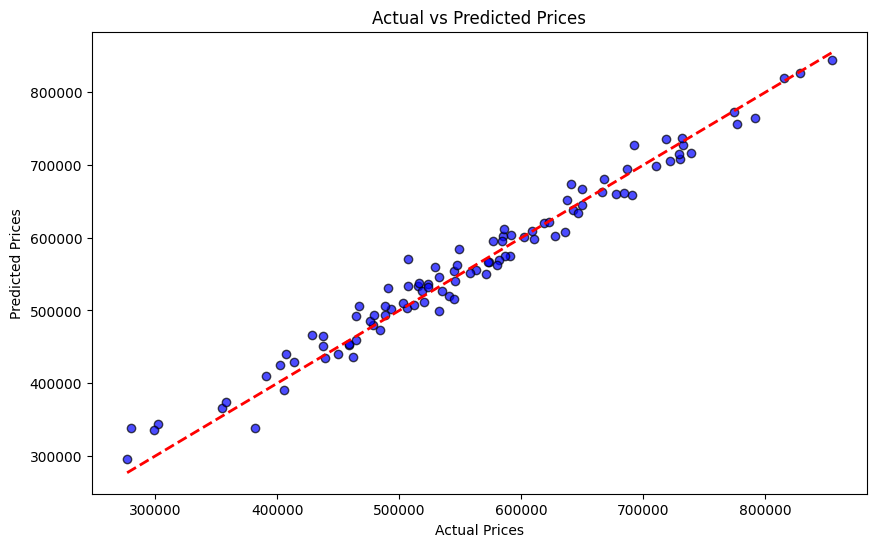

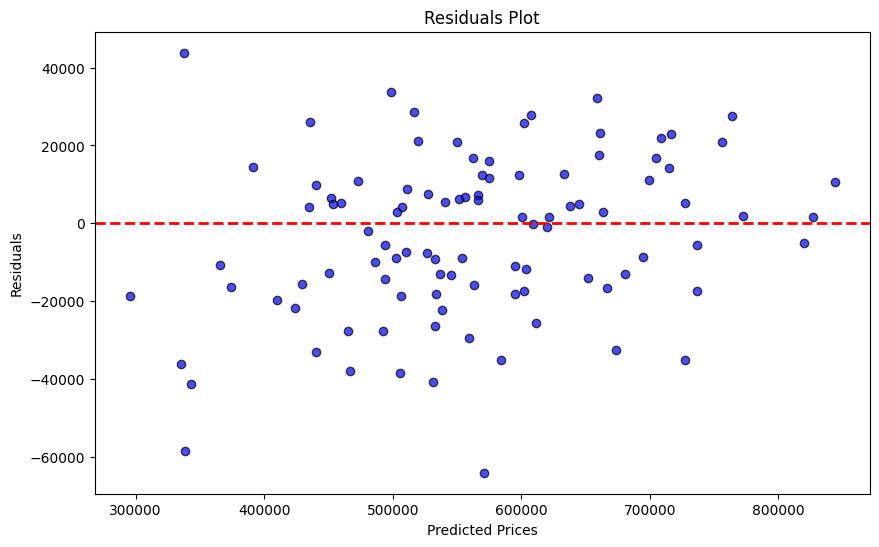

In [36]:
# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='black', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

# Plotting the residuals (differences between actual and predicted values)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title("Residuals Plot")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.show()

**Note:** The spread of residuals seems fairly consistent across different predicted price ranges. This indicates that the model's error variance is not increasing or decreasing with the predicted values, fulfilling the assumption of homoscedasticity.

In [39]:
# # Create a pickle file for my pipeline
with open('/content/drive/MyDrive/datasets/model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)